In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

## Load the data

In [4]:
# Download the dataset
path = '''http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'''
data = pd.read_csv(path, header=None)
print(data.shape)
data.head()

(4998, 141)


,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


## Split the data for training and testing

In [5]:
# last column is the target
# 0 = anomaly, 1 = normal
TARGET = 140

features = data.drop(TARGET, axis=1)
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, 
    random_state = 0, stratify=target
)

In [6]:
x_test.shape

(1000, 140)

In [7]:
x_train.shape

(3998, 140)

In [8]:
target.value_counts()

1.0    2919
0.0    2079
Name: 140, dtype: int64

In [9]:
# use case is novelty detection so use only the normal data
# for training
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

## Scale the data using MinMaxScaler

In [10]:
min_max_scaler = MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(
    train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [11]:
x_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
count,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,...,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000,3998.000000
mean,-0.243013,-1.627465,-2.479011,-3.111913,-3.169065,-2.872239,-2.275887,-1.799358,-1.415414,-0.939314,...,0.148492,0.073799,-0.058467,-0.270279,-0.502176,-0.758937,-0.836047,-0.647518,-0.493972,-0.713897
std,1.156946,1.447211,1.385123,1.305425,1.113079,0.913680,0.735427,0.627262,0.638972,0.658135,...,1.169235,1.400637,1.644299,1.894875,2.062116,2.088599,2.058335,1.864085,1.838581,1.422700
min,-6.729499,-7.090374,-5.132459,-5.324706,-5.375715,-5.217053,-4.512132,-4.311288,-4.071361,-4.142476,...,-3.922664,-4.167040,-4.557576,-4.530488,-4.563270,-4.911417,-4.880460,-5.204841,-5.880890,-6.038676
25%,-0.988147,-2.679589,-3.650456,-4.222552,-4.017797,-3.494802,-2.786853,-2.163895,-1.777667,-1.357224,...,-0.649464,-1.086458,-1.573847,-2.132587,-2.716312,-3.042991,-2.868170,-2.186954,-1.688864,-1.600440
50%,-0.282004,-1.640674,-2.578471,-3.387353,-3.482953,-2.952360,-2.289780,-1.751067,-1.423344,-0.910487,...,0.475714,0.668296,0.723911,0.604151,0.334857,-0.015847,-0.177322,-0.197992,-0.156525,-0.580120
75%,0.532473,-0.648556,-1.504884,-2.234290,-2.525682,-2.409076,-1.827482,-1.484107,-1.069879,-0.486283,...,1.065664,1.160985,1.238319,1.270414,1.236481,1.036482,0.943096,0.951049,1.002820,0.270077
max,4.966414,3.479689,2.660597,1.899798,2.147015,1.614375,1.868728,1.804251,1.658109,1.850844,...,2.960969,3.007606,2.854680,2.912134,2.937685,3.351437,3.432519,3.579448,4.425976,7.402103


In [12]:
pd.DataFrame(x_train_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
count,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,...,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000,2335.000000
mean,0.544746,0.469984,0.274483,0.259759,0.265531,0.347222,0.389287,0.433025,0.436442,0.397885,...,0.606361,0.569424,0.627037,0.647769,0.645779,0.605974,0.611551,0.654696,0.672568,0.561737
std,0.108186,0.136394,0.148195,0.134715,0.099682,0.127931,0.128073,0.085960,0.108409,0.127450,...,0.138016,0.120901,0.120632,0.138202,0.163818,0.161135,0.146557,0.131368,0.145253,0.154679
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.470612,0.373531,0.166064,0.173326,0.207592,0.259683,0.298745,0.393824,0.360579,0.312547,...,0.536913,0.523651,0.576003,0.595374,0.579923,0.536645,0.541370,0.581569,0.577163,0.455030
50%,0.534498,0.447919,0.244325,0.222024,0.254606,0.334196,0.405625,0.432087,0.416598,0.399819,...,0.635128,0.589261,0.641787,0.671108,0.677809,0.639393,0.647042,0.686346,0.697374,0.568847
75%,0.616405,0.546008,0.347583,0.310697,0.305755,0.426743,0.478648,0.468360,0.491421,0.475334,...,0.698318,0.641161,0.698702,0.733196,0.752581,0.715468,0.710331,0.749226,0.777994,0.673478
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Build an AutoEncoder model

In [13]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [14]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=20,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 9s 286ms/step - loss: 0.0108 - mse: 0.0242 - val_loss: 0.0131 - val_mse: 0.0304
Epoch 2/20
5/5 [==============================] - 0s 31ms/step - loss: 0.0102 - mse: 0.0230 - val_loss: 0.0128 - val_mse: 0.0296
Epoch 3/20
5/5 [==============================] - 0s 39ms/step - loss: 0.0094 - mse: 0.0210 - val_loss: 0.0127 - val_mse: 0.0293
Epoch 4/20
5/5 [==============================] - 0s 34ms/step - loss: 0.0084 - mse: 0.0188 - val_loss: 0.0122 - val_mse: 0.0283
Epoch 5/20
5/5 [==============================] - 0s 46ms/step - loss: 0.0075 - mse: 0.0167 - val_loss: 0.0115 - val_mse: 0.0265
Epoch 6/20
5/5 [==============================] - 0s 37ms/step - loss: 0.0067 - mse: 0.0148 - val_loss: 0.0111 - val_mse: 0.0257
Epoch 7/20
5/5 [==============================] - 0s 31ms/step - loss: 0.0061 - mse: 0.0134 - val_loss: 0.0105 - val_mse: 0.0244
Epoch 8/20
5/5 [==============================] - 0s 42ms/step - loss: 0.0056 - mse: 0.0125 - va

## Plot history

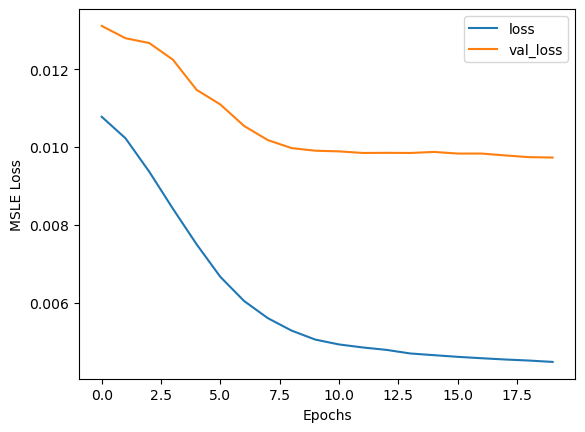

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()